# Introduction 
* This code is adapted from the example provided in the python optimal transport package 

This notebook presents the results of mapping a 1D uniform input distribution to a 2D uniform target distribution using 3 different network sizes (in this order: large, small, medium). 


## Imports

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as pl
import matplotlib.animation as animation
import torch
from torch import nn
import ot
import random
# import sys\
# !{sys.executable} -m pip install pot

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

seed = 126
torch.manual_seed(seed) # make chunk execution consistent 


__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 4080
__CUDA Device Total Memory [GB]: 16.860184576


## Data Functions

In [2]:
torch.manual_seed(seed) # make chunk execution consistent 

sigma = 0.0
n_dims = 2
n_features = 1


def get_data(n_samples):
    # c = torch.rand(size=(n_samples, 2))
    c1 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c2 = torch.arange(1, n_samples+1) / (n_samples)# .reshape((n_samples, 1)) / (n_samples)
    c = torch.cartesian_prod(c1,c2)
    x = c
    return x

def get_data_normal(n_samples):
    c = torch.randn(n_samples**2, 2) # match previous
    # c = 1/(1+torch.exp(-0.5*c))
    x = c
    return x

# empirical fill-based loss  
from scipy.spatial.distance import cdist
def fill_distance(data, fitted, type='max'): 
    m = torch.tensor(cdist(data, fitted, 'euclidean')) 
    # m = cdist(data, fitted, 'euclidean')
    min, min_indices = torch.min(m, dim=1) # min across rows 
    if type=='max':
        fill_dist = max(min)
    elif type=='mean':
        fill_dist = torch.mean(min)
    else:
        fill_dist = max(min)

    return fill_dist.item() # get actual float 


## Plot data



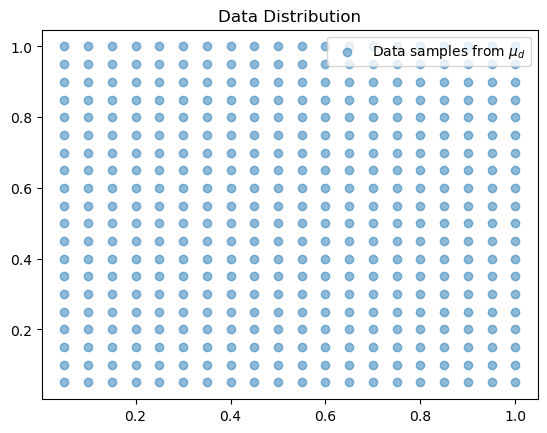

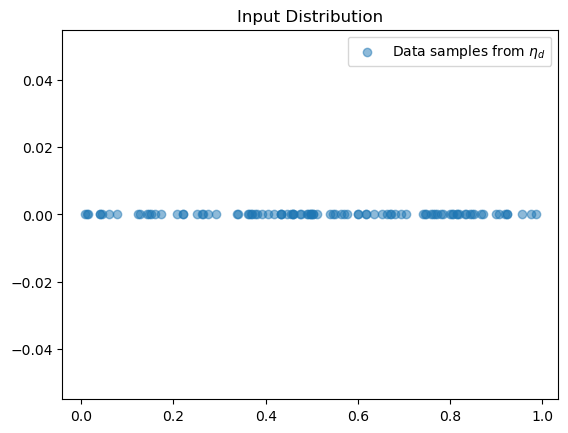

In [3]:
torch.manual_seed(seed) # make chunk execution consistent 

# plot the distributions
x = get_data(20)
pl.figure(1)
pl.scatter(x[:, 0], x[:, 1], label='Data samples from $\mu_d$', alpha=0.5)
pl.title('Data Distribution')
pl.legend()

xn = torch.rand(100, n_features)
yn = torch.zeros(100)
pl.figure(2)
# pl.scatter(xn[:, 0], xn[:, 1], label='Data samples from $\eta_d$', alpha=0.5)
pl.scatter(xn[:, 0],yn, label='Data samples from $\eta_d$', alpha=0.5)
pl.title('Input Distribution')
pl.legend()


## Generator Model



In [11]:
torch.manual_seed(seed) # make chunk execution consistent 


class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 1
        self.n_out = 2
        n= 200
        leaky = 0.0001
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            # nn.Linear(n, self.n_out),
        )
        self.model.append(nn.Linear(n, self.n_out))
        
    def forward(self, x):
        x = self.model(x)
        return x
    
class Generator2(torch.nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.n_features = 1
        self.n_out = 2
        n= 10 # 50, 10000 iterations does not give super close approximation 
        leaky = 0.0001
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, self.n_out),
        )
    def forward(self, x):
        x = self.model(x)
        return x
            
class Generator3(torch.nn.Module):
    def __init__(self):
        super(Generator3, self).__init__()
        self.n_features = 1
        self.n_out = 2
        n= 100
        leaky = 0.0001
        self.model = nn.Sequential( 
            nn.Linear(self.n_features, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, n),
            nn.LeakyReLU(leaky),
            nn.Linear(n, self.n_out),
        )
    def forward(self, x):
        x = self.model(x)
        return x
    
g1 = Generator()
g2 = Generator2()
g3 = Generator3()
num_hidden_layers = sum(1 for _ in g1.modules() if isinstance(_, nn.Linear)) -1
print(f"The number of hidden layers in G1 is: {num_hidden_layers}")
num_hidden_layers = sum(1 for _ in g2.modules() if isinstance(_, nn.Linear)) -1
print(f"The number of hidden layers in G2 is: {num_hidden_layers}")
num_hidden_layers = sum(1 for _ in g3.modules() if isinstance(_, nn.Linear))-1
print(f"The number of hidden layers in G3 is: {num_hidden_layers}")

            

The number of hidden layers in G1 is: 5
The number of hidden layers in G2 is: 2
The number of hidden layers in G3 is: 3


## Training the model



Iter: 0, 	 wass-loss=0.75493, 	 fill-dist=0.81965
Iter: 10, 	 wass-loss=0.11908, 	 fill-dist=0.16705
Iter: 20, 	 wass-loss=0.07619, 	 fill-dist=0.17543
Iter: 30, 	 wass-loss=0.05647, 	 fill-dist=0.16875
Iter: 40, 	 wass-loss=0.05022, 	 fill-dist=0.1624
Iter: 50, 	 wass-loss=0.03555, 	 fill-dist=0.15121
Iter: 60, 	 wass-loss=0.03242, 	 fill-dist=0.13573
Iter: 70, 	 wass-loss=0.02796, 	 fill-dist=0.12164
Iter: 80, 	 wass-loss=0.0222, 	 fill-dist=0.11205
Iter: 90, 	 wass-loss=0.0188, 	 fill-dist=0.10623
Iter: 100, 	 wass-loss=0.0162, 	 fill-dist=0.09772
Iter: 110, 	 wass-loss=0.01478, 	 fill-dist=0.09078
Iter: 120, 	 wass-loss=0.01211, 	 fill-dist=0.08413
Iter: 130, 	 wass-loss=0.01136, 	 fill-dist=0.07804
Iter: 140, 	 wass-loss=0.01022, 	 fill-dist=0.07471
Iter: 150, 	 wass-loss=0.01071, 	 fill-dist=0.0725
Iter: 160, 	 wass-loss=0.00968, 	 fill-dist=0.06918
Iter: 170, 	 wass-loss=0.00896, 	 fill-dist=0.06764
Iter: 180, 	 wass-loss=0.00852, 	 fill-dist=0.0641
Iter: 190, 	 wass-loss=0.0077

Text(0.5, 0, 'Iterations')

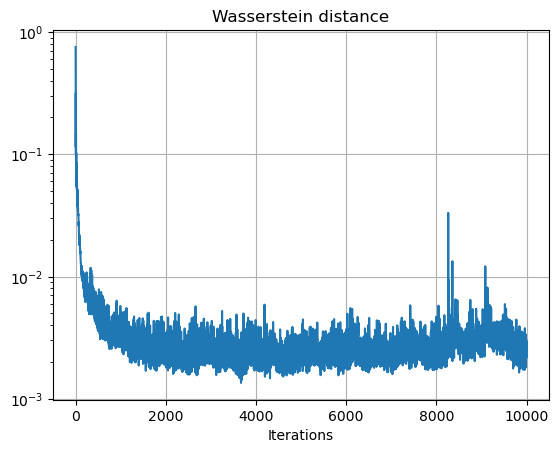

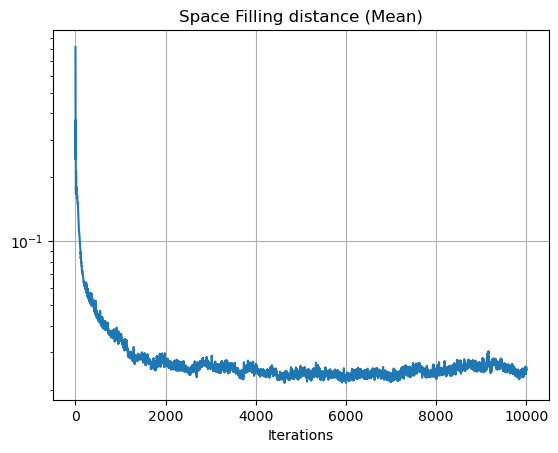

In [5]:
torch.manual_seed(seed) # make chunk execution consistent 

G = Generator()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-6)
# optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5, weight_decay=1e-15)

# number of iteration and size of the batches
n_iter = 10000 
size_batch = 30 # need to square this to facilitate cartesian product in get_data()

# generate static samples to see their trajectory along training
n_visu = 2000
xnvisu = torch.arange(1, n_visu+1).reshape((n_visu, n_features)) / (n_visu)
xnvisu = torch.randn(n_visu, n_features)

xvisu = torch.zeros(n_iter, n_visu, n_dims)
ab = torch.ones(size_batch**2) / size_batch**2 
losses = []
fill_losses = []

# train mode
G.train()

 # generate data samples
xd = get_data(size_batch) # constant grid 

for i in range(n_iter):

    # generate noise samples
    xn = torch.randn(size_batch**2, n_features) # random sample every iteration 
    # xn = torch.arange(1, size_batch**2+1).reshape((size_batch**2, n_features)) / (size_batch**2)

    # generate sample along iterations
    G.eval()
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate samples and compute distance matrix
    G.train()
    xg = G(xn)

    M = ot.dist(xg, xd)
    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))
    # print(losses)

    fill_loss = fill_distance(xd.detach().numpy(), xg.detach().numpy(), type='mean')
    fill_losses.append(fill_loss)

    if i % 10 == 0:
        # print("Iter: {:3d}, loss={}".format(i, losses[-1]))
        print(f"Iter: {i}, \t wass-loss={round(losses[-1], 5)}, \t fill-dist={round(fill_loss, 5)}")

    loss.backward()
    optimizer.step()

    del M
    
pl.figure(2)
pl.semilogy(losses)
pl.grid()
pl.title('Wasserstein distance')
pl.xlabel("Iterations")

pl.figure(3)
pl.semilogy(fill_losses)
pl.grid()
pl.title('Space Filling distance (Mean)')
pl.xlabel("Iterations")

## Plot trajectories of generated samples along iterations



[0.8305423193947464, 0.09703631571430466, 0.06149280820547487, 0.04396536273680178, 0.035140827250492376, 0.021813410135992087, 0.022080136633372716, 0.021871752103678522, 0.020775307770418108]


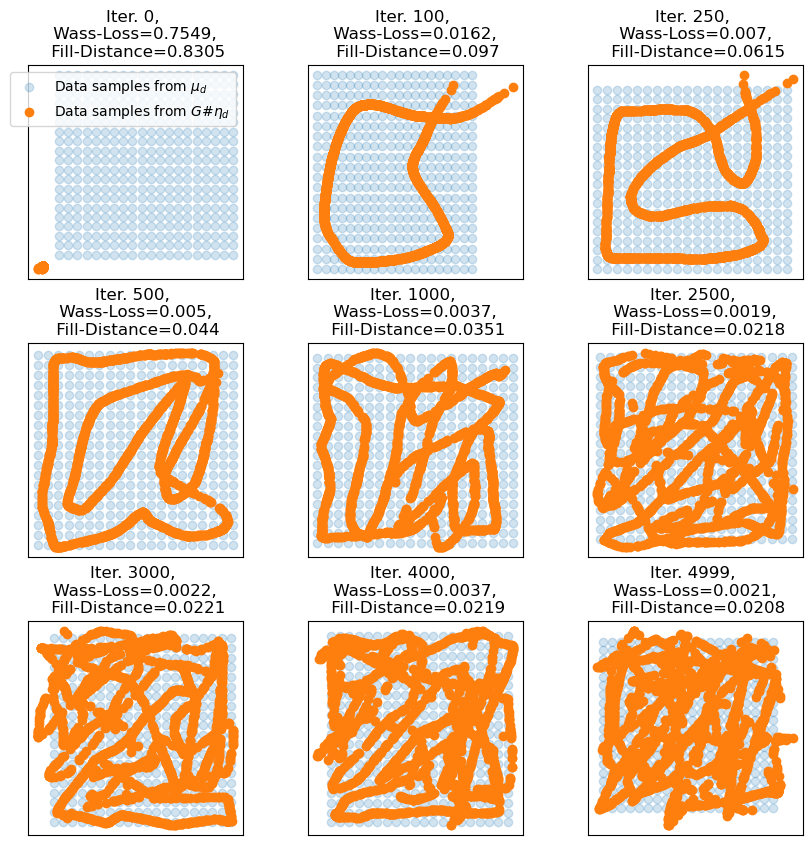

In [6]:
torch.manual_seed(seed) # make chunk execution consistent 

# ivisu = [0, 10, 50, 100, 150, 1000, n_iter-500, n_iter-250, n_iter-1]
ivisu = [0, 100, 250, 500, 1000, 2500, 5000, 7500, n_iter-1]
ivisu = [0, 100, 250, 500, 1000, 2500, 3000, 4000, 4999]

xd = get_data(20)
fill_distances = []

pl.figure(3, (10, 10))

for i in range(9):
    fill_distances.append(fill_distance(xd, xvisu[ivisu[i], :], type='mean'))

    pl.subplot(3, 3, i + 1)

    # Use the distances to map to colors
    progression = np.linspace(0, 1, n_visu)  # Normalize progression to [0, 1]
    
    pl.scatter(xd[:, 0], xd[:, 1], label='Data samples from $\mu_d$', alpha=0.2)
    pl.scatter(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], 
               label='Data samples from $G\#\eta_d$', 
               alpha=1,
                #c = progression,
                #cmap='Oranges'
                )

    pl.xticks(())
    pl.yticks(())
    pl.title(f'Iter. {ivisu[i]}, \n Wass-Loss={round(losses[ivisu[i]], 4)}, \n Fill-Distance={round(fill_distances[-1], 4)}')
    if i == 0:
        pl.legend()
    
# adjust the spacing
pl.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

print(fill_distances)


## Generator - unif to normal



Iter: 0, 	 wass-loss=1.90003, 	 fill-dist=1.22107
Iter: 10, 	 wass-loss=2.03549, 	 fill-dist=0.82914
Iter: 20, 	 wass-loss=1.31202, 	 fill-dist=0.93547
Iter: 30, 	 wass-loss=1.10276, 	 fill-dist=0.78111
Iter: 40, 	 wass-loss=1.00423, 	 fill-dist=0.81172
Iter: 50, 	 wass-loss=0.94928, 	 fill-dist=0.78101
Iter: 60, 	 wass-loss=0.92719, 	 fill-dist=0.77183
Iter: 70, 	 wass-loss=0.90744, 	 fill-dist=0.75981
Iter: 80, 	 wass-loss=0.85962, 	 fill-dist=0.74157
Iter: 90, 	 wass-loss=0.75163, 	 fill-dist=0.69162
Iter: 100, 	 wass-loss=0.59919, 	 fill-dist=0.59895
Iter: 110, 	 wass-loss=0.4668, 	 fill-dist=0.51076
Iter: 120, 	 wass-loss=0.46666, 	 fill-dist=0.48187
Iter: 130, 	 wass-loss=0.41951, 	 fill-dist=0.49619
Iter: 140, 	 wass-loss=0.41342, 	 fill-dist=0.504
Iter: 150, 	 wass-loss=0.40533, 	 fill-dist=0.48219
Iter: 160, 	 wass-loss=0.37108, 	 fill-dist=0.47218
Iter: 170, 	 wass-loss=0.38616, 	 fill-dist=0.44867
Iter: 180, 	 wass-loss=0.34684, 	 fill-dist=0.41002
Iter: 190, 	 wass-loss=0.2

Text(0.5, 0, 'Iterations')

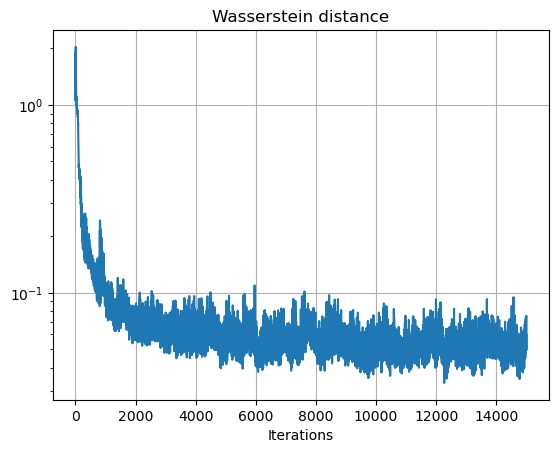

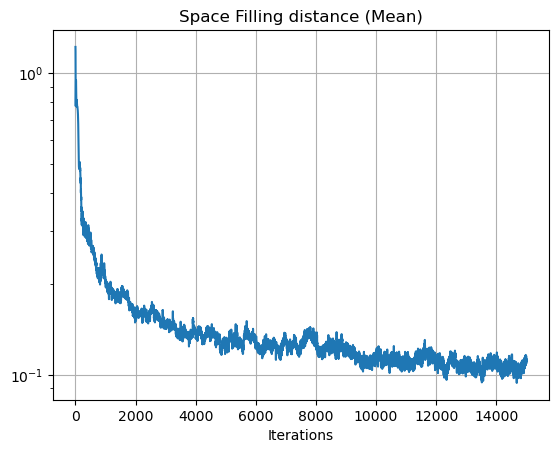

In [7]:
torch.manual_seed(seed) # make chunk execution consistent 

G = Generator()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-6)
# optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5, weight_decay=1e-15)

# number of iteration and size of the batches
n_iter = 15000 # was 10000
size_batch = 30 # need to square this to facilitate cartesian product in get_data()

# generate static samples to see their trajectory along training
n_visu = 1000
xnvisu = torch.arange(1, n_visu+1).reshape((n_visu, n_features)) / (n_visu)
# xnvisu = torch.randn(n_visu, n_features)

xvisu = torch.zeros(n_iter, n_visu, n_dims)
ab = torch.ones(size_batch**2) / size_batch**2 
losses = []
fill_losses = []

# train mode
G.train()

 # generate data samples
xd = get_data_normal(size_batch) # constant grid 

for i in range(n_iter):

    # generate noise samples
    xn = torch.rand(size_batch**2, n_features) # random sample every iteration 
    # xn = torch.arange(1, size_batch**2+1).reshape((size_batch**2, n_features)) / (size_batch**2)

    # generate sample along iterations
    G.eval()
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate samples and compute distance matrix
    G.train()
    xg = G(xn)

    M = ot.dist(xg, xd)
    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))
    # print(losses)

    fill_loss = fill_distance(xd.detach().numpy(), xg.detach().numpy(), type='mean')
    fill_losses.append(fill_loss)

    if i % 10 == 0:
        # print("Iter: {:3d}, loss={}".format(i, losses[-1]))
        print(f"Iter: {i}, \t wass-loss={round(losses[-1], 5)}, \t fill-dist={round(fill_loss, 5)}")

    loss.backward()
    optimizer.step()

    del M
    
pl.figure(2)
pl.semilogy(losses)
pl.grid()
pl.title('Wasserstein distance')
pl.xlabel("Iterations")

pl.figure(3)
pl.semilogy(fill_losses)
pl.grid()
pl.title('Space Filling distance (Mean)')
pl.xlabel("Iterations")

[1.236003416800571, 0.6368967866413484, 0.3261218936314027, 0.308382702497324, 0.2185817910191087, 0.13493987314176656, 0.11763990483405166, 0.10885338586038182, 0.10570349754230171]


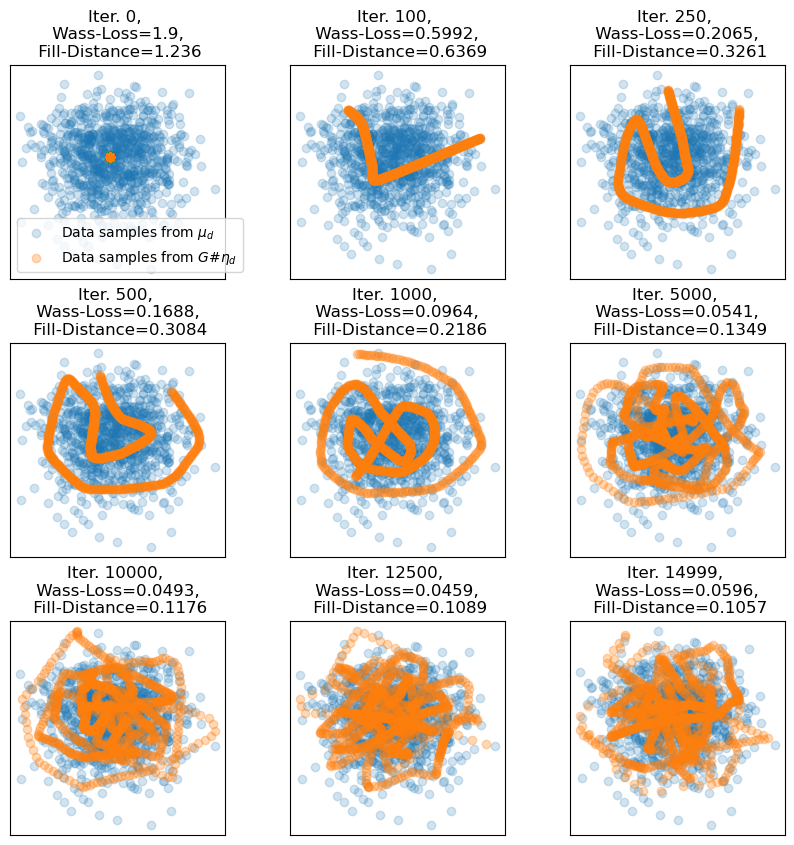

In [8]:
torch.manual_seed(seed) # make chunk execution consistent 

# ivisu = [0, 10, 50, 100, 150, 1000, n_iter-500, n_iter-250, n_iter-1]
ivisu = [0, 100, 250, 500, 1000, 2500, 5000, 7500, n_iter-1]
ivisu = [0, 100, 250, 500, 1000, 5000, 10000, 12500, n_iter-1]


xd = get_data_normal(30)
fill_distances = []

pl.figure(3, (10, 10))

for i in range(9):
    fill_distances.append(fill_distance(xd, xvisu[ivisu[i], :], type='mean'))

    pl.subplot(3, 3, i + 1)

    # Use the distances to map to colors
    progression = np.linspace(0, 1, n_visu)  # Normalize progression to [0, 1]
    
    pl.scatter(xd[:, 0], xd[:, 1], label='Data samples from $\mu_d$', alpha=0.2)
    pl.scatter(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], 
               label='Data samples from $G\#\eta_d$', 
               alpha=.3,
                #c = progression,
                #cmap='Oranges'
                )

    pl.xticks(())
    pl.yticks(())
    pl.title(f'Iter. {ivisu[i]}, \n Wass-Loss={round(losses[ivisu[i]], 4)}, \n Fill-Distance={round(fill_distances[-1], 4)}')
    if i == 0:
        pl.legend()
    
# adjust the spacing
pl.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

print(fill_distances)


## Generator - Normal to Normal

Iter: 0, 	 wass-loss=2.03823, 	 fill-dist=1.26297


Iter: 10, 	 wass-loss=0.93426, 	 fill-dist=0.76332
Iter: 20, 	 wass-loss=0.59249, 	 fill-dist=0.582
Iter: 30, 	 wass-loss=0.46615, 	 fill-dist=0.51613
Iter: 40, 	 wass-loss=0.41189, 	 fill-dist=0.48568
Iter: 50, 	 wass-loss=0.43011, 	 fill-dist=0.4808
Iter: 60, 	 wass-loss=0.39634, 	 fill-dist=0.48169
Iter: 70, 	 wass-loss=0.38835, 	 fill-dist=0.47952
Iter: 80, 	 wass-loss=0.36703, 	 fill-dist=0.46693
Iter: 90, 	 wass-loss=0.37544, 	 fill-dist=0.46026
Iter: 100, 	 wass-loss=0.36898, 	 fill-dist=0.45792
Iter: 110, 	 wass-loss=0.3629, 	 fill-dist=0.44407
Iter: 120, 	 wass-loss=0.30828, 	 fill-dist=0.41523
Iter: 130, 	 wass-loss=0.29427, 	 fill-dist=0.39343
Iter: 140, 	 wass-loss=0.26566, 	 fill-dist=0.37675
Iter: 150, 	 wass-loss=0.24617, 	 fill-dist=0.36056
Iter: 160, 	 wass-loss=0.22803, 	 fill-dist=0.35174
Iter: 170, 	 wass-loss=0.23024, 	 fill-dist=0.3495
Iter: 180, 	 wass-loss=0.18981, 	 fill-dist=0.32814
Iter: 190, 	 wass-loss=0.18604, 	 fill-dist=0.31175
Iter: 200, 	 wass-loss=0.1

Text(0.5, 0, 'Iterations')

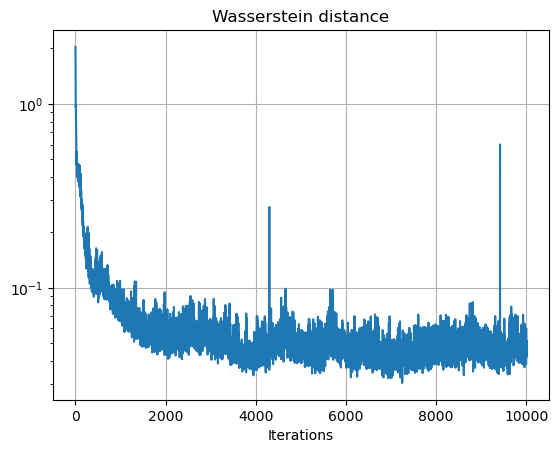

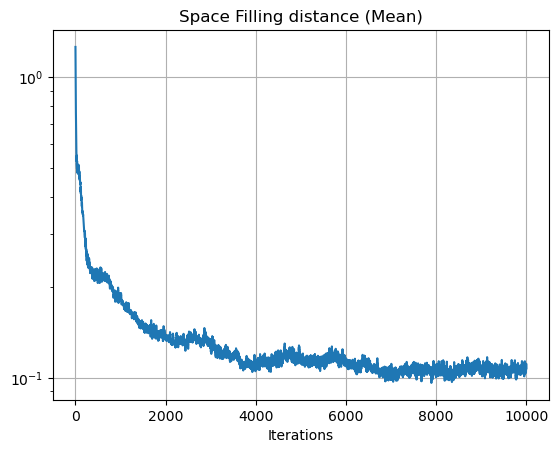

In [9]:
torch.manual_seed(seed) # make chunk execution consistent 

G = Generator()
optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-6)
# optimizer = torch.optim.RMSprop(G.parameters(), lr=0.00019, eps=1e-5, weight_decay=1e-15)

# number of iteration and size of the batches
n_iter = 10000 # was 10000
size_batch = 30 # need to square this to facilitate cartesian product in get_data()

# generate static samples to see their trajectory along training
n_visu = 1000
# xnvisu = torch.arange(1, n_visu+1).reshape((n_visu, n_features)) / (n_visu)
xnvisu = torch.randn(n_visu, n_features)

xvisu = torch.zeros(n_iter, n_visu, n_dims)
ab = torch.ones(size_batch**2) / size_batch**2 
losses = []
fill_losses = []

# train mode
G.train()

 # generate data samples
xd = get_data_normal(size_batch) # constant grid 

for i in range(n_iter):

    # generate noise samples
    xn = torch.randn(size_batch**2, n_features) # random sample every iteration 
    # xn = torch.arange(1, size_batch**2+1).reshape((size_batch**2, n_features)) / (size_batch**2)

    # generate sample along iterations
    G.eval()
    xvisu[i, :, :] = G(xnvisu).detach()

    # generate samples and compute distance matrix
    G.train()
    xg = G(xn)

    M = ot.dist(xg, xd)
    loss = ot.emd2(ab, ab, M)
    losses.append(float(loss.detach()))
    # print(losses)

    fill_loss = fill_distance(xd.detach().numpy(), xg.detach().numpy(), type='mean')
    fill_losses.append(fill_loss)

    if i % 10 == 0:
        # print("Iter: {:3d}, loss={}".format(i, losses[-1]))
        print(f"Iter: {i}, \t wass-loss={round(losses[-1], 5)}, \t fill-dist={round(fill_loss, 5)}")

    loss.backward()
    optimizer.step()

    del M
    
pl.figure(2)
pl.semilogy(losses)
pl.grid()
pl.title('Wasserstein distance')
pl.xlabel("Iterations")

pl.figure(3)
pl.semilogy(fill_losses)
pl.grid()
pl.title('Space Filling distance (Mean)')
pl.xlabel("Iterations")

[1.226805512295084, 0.44634925910923157, 0.2641516983673061, 0.23467047276386452, 0.19937270938515245, 0.1357712484809979, 0.12305386400392784, 0.10973030203385956, 0.11439372611669006]


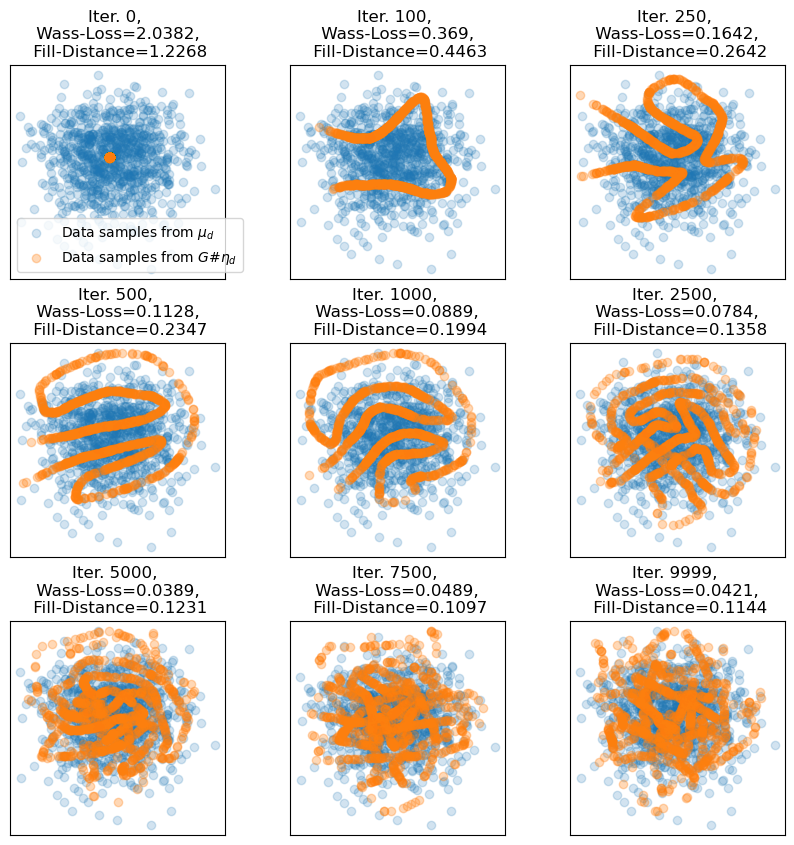

In [10]:
torch.manual_seed(seed) # make chunk execution consistent 

# ivisu = [0, 10, 50, 100, 150, 1000, n_iter-500, n_iter-250, n_iter-1]
ivisu = [0, 100, 250, 500, 1000, 2500, 5000, 7500, n_iter-1]

xd = get_data_normal(30)
fill_distances = []

pl.figure(3, (10, 10))

for i in range(9):
    fill_distances.append(fill_distance(xd, xvisu[ivisu[i], :], type='mean'))

    pl.subplot(3, 3, i + 1)

    # Use the distances to map to colors
    progression = np.linspace(0, 1, n_visu)  # Normalize progression to [0, 1]
    
    pl.scatter(xd[:, 0], xd[:, 1], label='Data samples from $\mu_d$', alpha=0.2)
    pl.scatter(xvisu[ivisu[i], :, 0], xvisu[ivisu[i], :, 1], 
               label='Data samples from $G\#\eta_d$', 
               alpha=.3,
                #c = progression,
                #cmap='Oranges'
                )

    pl.xticks(())
    pl.yticks(())
    pl.title(f'Iter. {ivisu[i]}, \n Wass-Loss={round(losses[ivisu[i]], 4)}, \n Fill-Distance={round(fill_distances[-1], 4)}')
    if i == 0:
        pl.legend()
    
# adjust the spacing
pl.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

print(fill_distances)
